# Evaluation of the processed amplitude *using raw data*

This processor uses the averaged data of the amplitude analyser rather than the approximated hyoerbolic function.

# Setup

In [55]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pickle
from colorama import Fore, Back, Style
import plotting_util
from reportlab.lib import pagesizes
from reportlab.lib.units import mm
from reportlab.lib import pagesizes
A6_LS = pagesizes.landscape(pagesizes.A6)
PAGE_SMALL = (160 * mm, 80 * mm)

import configuration as cfg


In [56]:
# Import serialized symmetrical list to file
def import_list_binary(filename: str):
    with open(filename + '.dat', 'rb') as fd:
        list = pickle.load(fd)
    return list


symm_array = import_list_binary("data/hyperbolic_raw_data_symm")


# Umrechnung von Amplitude auf Schallpegel (RMS) \[dB\]

Pseudocode Umrechnungsfunktionen:
```python
# a: Amplitude
amp_to_db(a: float) = 20 * log10(a)
amp_to_rms(a: float) = amp_to_db(sqrt((a * a) / 2))
```

In [57]:
def __amp_to_db(amplitude):
    """
    IMPORTANT: Returns a numpy array
    """
    return 20 * np.log10(amplitude)

def amp_to_rms(amplitude):
    amplitude = np.array(amplitude)
    return __amp_to_db(np.sqrt((np.multiply(amplitude, amplitude)) / 2))


if __name__ == "__main__":
    print("test")
    print(amp_to_rms([0, 0.25, 0.5, 0.75, 1]))
    print(amp_to_rms([1, 0.75, 0.5, 0.25, 0]))

test
[        -inf -15.05149978  -9.03089987  -5.50907469  -3.01029996]
[ -3.01029996  -5.50907469  -9.03089987 -15.05149978         -inf]


C:\Users\Levin\AppData\Local\Temp\ipykernel_16040\3952447410.py:5: RuntimeWarning: divide by zero encountered in log10
  return 20 * np.log10(amplitude)


<Figure size 640x480 with 0 Axes>

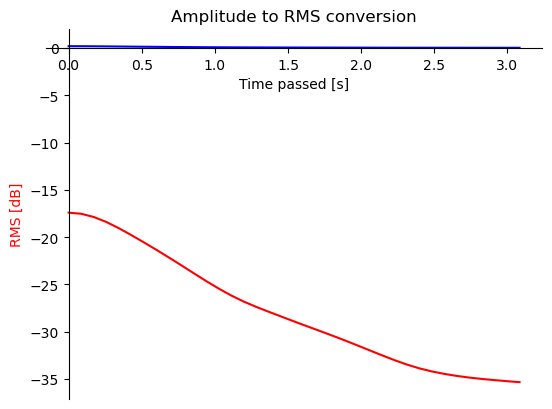

time increment: 1,0 s
-24,66580197398239	-31,427926327037206	-35,23931103000772	



In [58]:
plotting_util.plot_amplitude_data(
    "Amplitude to RMS conversion", "Hyperbola (optimal_a)", cfg.averaging_resolution, data1=symm_array, axis2_name="RMS [dB]", data2=amp_to_rms(symm_array), graph_on_same_axis=True)

rms_curve = amp_to_rms(symm_array)

amt_print_vals = 3 # minimum of 3
num_samples = len(rms_curve)
sample_increment = int(num_samples / amt_print_vals)
time_increment = sample_increment / cfg.averaging_resolution
rms_vals = [(rms_curve[sample_increment * (i + 1) - 1]) for i in range(amt_print_vals)]
print(f"time increment: {str(time_increment).replace('.', ',')} s")
for rms_value in rms_vals:
    print(str(rms_value).replace('.', ','), end='\t')

print('\n')

# Pythagoras correction

<span style="color:red; font-size:30pt;">fehlt momentan noch</span>

# Speed calculation

Using the data yielded by the amplitude to RMS converter, the speed of the passing vehicle is approximated.

Since the RMS curve is derived from a hyperbola, no extra precision is gained by calculating the speed at multiple points in time. However, due to the fact that the hyperbola is only an approximation of the actual amplitude curve, especially near $x = 0$, a value further from $0$ is picked (the hyperbola approaches a value of $\infty$ near $0$, which cannot be used in this formula).

See excel sheet "AmplitudeTest.xlsx" for empirical proof that speeds calculated with $x = 0$ including, differ from all other values.

In [59]:
r1 = 2.5 # radius_of_recording
L1 = 0 # maximum loudness

L2 = rms_vals[0]
L3 = rms_vals[1]

def radius2_from_3_known(radius1, Loudness1, Loudness2): # -> r2
    return radius1 * (10 ** (abs(Loudness1 - Loudness2) / 20))

r2 = radius2_from_3_known(r1, L1, L2)
r3 = radius2_from_3_known(r1, L1, L3)

v2_3 = (r3 - r2) / time_increment

print(Fore.BLACK + Back.CYAN + f"Approximated speed: {v2_3} [m/s] = {v2_3 * 3.6} [km/h]" + Style.RESET_ALL)

Approximated speed: 50.40397336297806 [m/s] = 181.454304106721 [km/h]


Multiple speed calculations with averaging

In [60]:
r1 = 2.5  # radius_of_recording
L1 = rms_curve[0]  # maximum loudness

def radius2_from_3_known(radius1, Loudness1, Loudness2):  # -> r2
    return radius1 * (10 ** (abs(Loudness1 - Loudness2) / 20))

# velocity calculation for every points in the RMS list
r_prev = r1
v_list = np.empty(len(rms_curve))
for L_x in rms_curve:
    r_x = radius2_from_3_known(r1, L1, L_x)
    # v = s/t  ;  t = 1/res
    v_prev_x = (r_x - r_prev) * cfg.averaging_resolution
    print(v_prev_x)
    v_list = np.append(v_list, v_prev_x)
    r_prev = r_x

v_avg = np.mean(v_list)
v_median = np.median(v_list)
v_min = np.min(v_list)
v_max = np.max(v_list)

print(Fore.BLACK + Back.CYAN +
      f"""Mininmum: {v_min} [m/s] = {v_min * 3.6} [km/h]
      Average: {v_avg} [m/s] = {v_avg * 3.6} [km/h]
      Median: {v_median} [m/s] = {v_median * 3.6} [km/h]
      Maximum: {v_max} [m/s] = {v_max * 3.6} [km/h]""" + Style.RESET_ALL)


0.0
0.4063817140386128
1.208342922077966
1.9683711700429694
2.6390772684100767
3.186584453361556
3.64134759948932
4.095382439508793
4.622752924438764
5.216737859607218
5.810351257291863
6.316588086171304
6.627205897678117
6.627520502251304
6.31763553362331
5.933630481102295
5.805201456058679
6.018460641123134
6.35268595768234
6.6123137139303765
6.878503476592478
7.351484968825801
8.061758057344143
8.844194629251298
9.542922865283629
10.101080889156869
10.385269670546947
10.084556101729554
9.053784278520219
7.636909145674579
6.349552534528115
5.349221276783055
4.486484649545332
3.7242845089912464
3.2106535460795698
3.0013231911210028
2.9341494489207633
Mininmum: 0.0 [m/s] = 0.0 [km/h]
      Average: 2.8254189357029524 [m/s] = 10.171508168530629 [km/h]
      Median: 0.18912314094369198 [m/s] = 0.6808433073972912 [km/h]
      Maximum: 10.385269670546947 [m/s] = 37.38697081396901 [km/h]
